### Imports

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import scipy.stats as stats
from scipy.stats import spearmanr
import statsmodels.stats.diagnostic as diag
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, scale
from sklearn.linear_model import LinearRegression
from scipy.stats import normaltest
import statsmodels.api as sm
from sklearn.cluster import KMeans
import warnings

random_state = 42

### Data Upload

In [2]:
df = pd.read_csv('./data/train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


### Data Preprocessing

#### Handling Missing Values

In [3]:
# Remove rows with missing values in 'MasVnrType', 'MasVnrArea', and 'Electrical' columns.
df.dropna(subset=['MasVnrType', 'MasVnrArea', 'Electrical'], inplace=True)

In [4]:
# Impute missing LotFrontage values based on the median LotFrontage within each neighborhood.
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

/opt/homebrew/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [5]:
# Fill missing values in FireplaceQu with 'None'.
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')

In [6]:
# Fill missing values in garage-related variables with 'None'.
df['GarageType'] = df['GarageType'].fillna('None')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
df['GarageFinish'] = df['GarageFinish'].fillna('None')
df['GarageQual'] = df['GarageQual'].fillna('None')
df['GarageCond'] = df['GarageCond'].fillna('None')

In [7]:
# Fill missing values in basement-related variables with 'None'.
df['BsmtQual'] = df['BsmtQual'].fillna('None')
df['BsmtCond'] = df['BsmtCond'].fillna('None')
df['BsmtExposure'] = df['BsmtExposure'].fillna('None')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('None')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('None')

In [8]:
# Drop columns with a high count of missing values
df.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

#### Encoding

In [9]:
nominalFeatures = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
                    'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
                    'Heating', 'CentralAir', 'Electrical', 'GarageType', 'SaleType',
                    'SaleCondition','PavedDrive']

ordinalFeatures = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual','FireplaceQu',
                    'GarageQual', 'GarageCond']

otherOrdinalFeatures = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish']

In [10]:
df = pd.get_dummies(df, columns = nominalFeatures)

In [11]:
ordinalCategories = [['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'] for _ in ordinalFeatures]

ordinalEncoder = OrdinalEncoder(categories=ordinalCategories)
ordinalEncoded = ordinalEncoder.fit_transform(df[ordinalFeatures])

for i, feature in enumerate(ordinalFeatures):
    df[feature] = ordinalEncoded[:, i]

In [12]:
encodingCategories = [
    ['None', 'No', 'Mn', 'Av', 'Gd'],  # BsmtExposure
    ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # BsmtFinType1
    ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # BsmtFinType2
    ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], # Functional
    ['None', 'Unf', 'RFn', 'Fin']  # GarageFinish
]

ordinalEncoder = OrdinalEncoder(categories=encodingCategories)
ordinalEncoded = ordinalEncoder.fit_transform(df[otherOrdinalFeatures])

for i, feature in enumerate(otherOrdinalFeatures):
    df[feature] = ordinalEncoded[:, i]

#### Splitting DataSet

In [13]:
df_cp = df.copy()
y = df_cp.pop('SalePrice')
X = df_cp

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=random_state)

In [15]:
print(X_train.shape)
print(X_test.shape)

(470, 191)
(118, 191)


### Decision Tree

In [16]:
clf = DecisionTreeRegressor(max_depth=4, random_state=random_state) 
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

[Text(0.5375, 0.9, 'OverallQual <= 7.5\nsquared_error = 7659150419.573\nsamples = 470\nvalue = 217507.47'),
 Text(0.325, 0.7, 'OverallQual <= 6.5\nsquared_error = 1823780184.301\nsamples = 333\nvalue = 177060.949'),
 Text(0.2, 0.5, 'GrLivArea <= 1260.0\nsquared_error = 988046478.79\nsamples = 207\nvalue = 156605.599'),
 Text(0.1, 0.3, 'LotArea <= 2500.5\nsquared_error = 520536638.591\nsamples = 87\nvalue = 135515.563'),
 Text(0.05, 0.1, 'squared_error = 164076875.0\nsamples = 8\nvalue = 92425.0'),
 Text(0.15, 0.1, 'squared_error = 349562773.859\nsamples = 79\nvalue = 139879.165'),
 Text(0.3, 0.3, 'OverallQual <= 5.5\nsquared_error = 1016999691.526\nsamples = 120\nvalue = 171895.875'),
 Text(0.25, 0.1, 'squared_error = 596304000.657\nsamples = 37\nvalue = 148100.135'),
 Text(0.35, 0.1, 'squared_error = 839595589.345\nsamples = 83\nvalue = 182503.614'),
 Text(0.45, 0.5, 'GrLivArea <= 2296.0\nsquared_error = 1937948653.466\nsamples = 126\nvalue = 210666.167'),
 Text(0.4, 0.3, 'squared_err

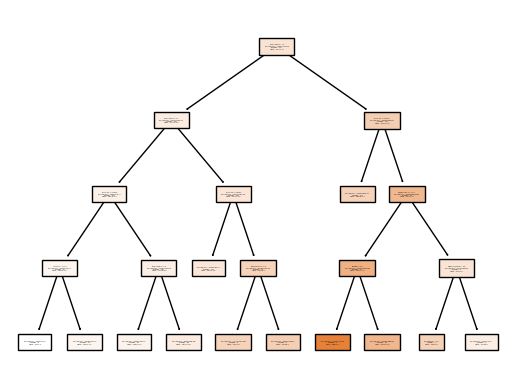

In [17]:
tree.plot_tree(clf,feature_names=df.columns, class_names=True, filled=True, fontsize=1)

In [18]:
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 3185385177.5965047
MAE: 36762.335995024936
R²: 0.6483173264796165


El modelo inicial, con una profundidad máxima de 4, logró un valor de R² cercano a 0.7. Por lo general, valores superiores a 0.7 se consideran aceptables, y este modelo se acerca bastante a este umbral. Sin embargo, aunque este modelo puede considerarse aceptable, es posible que ajustando los parámetros se pueda obtener un valor de R² aún más alto.

In [19]:
depths = range(3, 11)

for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Results for max depth = {depth}:")
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R²:", r2_score(y_test, y_pred))
    print("------------------------------------------------")


Results for max depth = 3:
MSE: 2991950907.527589
MAE: 36760.9255086387
R²: 0.6696734506076347
------------------------------------------------
Results for max depth = 4:
MSE: 3185385177.5965047
MAE: 36762.335995024936
R²: 0.6483173264796165
------------------------------------------------
Results for max depth = 5:
MSE: 3306313954.971548
MAE: 38258.50514719189
R²: 0.6349661763480974
------------------------------------------------
Results for max depth = 6:
MSE: 2589434168.4019294
MAE: 34443.88043174459
R²: 0.7141133393683496
------------------------------------------------
Results for max depth = 7:
MSE: 2342929810.2387104
MAE: 32970.571967507196
R²: 0.7413286702875068
------------------------------------------------
Results for max depth = 8:
MSE: 2410091716.045305
MAE: 34273.06196076952
R²: 0.7339136553753669
------------------------------------------------
Results for max depth = 9:
MSE: 3268150214.141206
MAE: 35495.85680965907
R²: 0.6391796468260635
------------------------------

Basado en los resultados, cada modelo tiene su propio conjunto de compensaciones.
- A medida que aumenta la profundidad, se observan mejoras progresivas en las métricas. Los valores de R² aumentan mientras que MSE y MAE disminuyen
- A partir de una profundidad de 7, la tasa de crecimiento de R² disminuye significativamente, llegando incluso a decrecer a partir de este punto.
- El valor más bajo de R² se obtiene con la profundidad máxima probada. Esto sugiere que, a partir de una profundidad de 7, es posible que comiencen a manifestarse los efectos de sobreajuste.

Con base en este análisis, el mejor modelo sería aquel con una profundidad de 7. Esto se debe a que presenta el valor más alto de R², lo que indica que es el que mejor explica la variabilidad de los precios de las casas.

### Classification Parameters

In [20]:
df.loc[:, df.columns == 'SalePrice'].describe()

,SalePrice
count,588.000000
mean,216458.091837
std,89205.954203
min,75000.000000
25%,155000.000000
50%,192250.000000
75%,260000.000000
max,755000.000000


En base al análisis exploratorio, se encontró que la variable SalePrice posee datos atípicos y no está distribuida normalmente. La mayoría de los datos se encuentran en un rango de precio entre 150,000 y 250,000, como se evidencia en la obtención de los cuartiles. Tomando esto en cuenta, se ha decidido clasificar las casas en base a sus precios de la siguiente manera:
- Casas más costosas: aquellas que superan un precio de 250,000.
- Casas intermedias: aquellas cuyo precio se encuentra entre 150,000 y 250,000.
- Casas económicas: aquellas cuyo precio se encuentra debajo de 150,000.

### Feature Creation

In [21]:
df_cp = df.copy()

conditions = [
    (df_cp['SalePrice'] < 150000),
    (df_cp['SalePrice'] >= 150000) & (df_cp['SalePrice'] <= 250000),
    (df_cp['SalePrice'] > 250000)
]

labels = ['economical', 'intermediate', 'expensive']

df_cp['SalePriceCategory'] = np.select(conditions, labels)

df_cp

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SalePriceCategory
0,1,60,65.0,8450,7,5,2003,2003,196.0,4.0,...,False,False,False,False,True,False,False,False,True,intermediate
2,3,60,68.0,11250,7,5,2001,2002,162.0,4.0,...,False,False,False,False,True,False,False,False,True,intermediate
4,5,60,84.0,14260,8,5,2000,2000,350.0,4.0,...,False,False,False,False,True,False,False,False,True,intermediate
6,7,20,75.0,10084,8,5,2004,2005,186.0,4.0,...,False,False,False,False,True,False,False,False,True,expensive
7,8,60,80.0,10382,7,6,1973,1973,240.0,3.0,...,False,False,False,False,True,False,False,False,True,intermediate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,1447,20,60.5,26142,5,7,1962,1962,189.0,3.0,...,False,False,False,False,True,False,False,True,False,intermediate
1447,1448,60,80.0,10000,8,5,1995,1996,438.0,4.0,...,False,False,False,False,True,False,False,False,True,intermediate
1451,1452,20,78.0,9262,8,5,2008,2009,194.0,4.0,...,False,False,False,False,False,True,False,False,True,expensive
1452,1453,180,35.0,3675,5,5,2005,2005,80.0,3.0,...,False,False,False,False,True,False,False,False,True,economical


In [22]:
y = df_cp.pop('SalePriceCategory')
X = df_cp.loc[:, ~df.columns.isin(['Id', 'SalePrice'])]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=random_state)

In [24]:
clf = DecisionTreeClassifier(max_depth=4, random_state=random_state) 
clf = clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)

[Text(0.5, 0.9, 'LotArea <= 7.5\ngini = 0.618\nsamples = 470\nvalue = [101.0, 129.0, 240.0]\nclass = y[2]'),
 Text(0.22, 0.7, 'LowQualFinSF <= 1144.5\ngini = 0.493\nsamples = 333\nvalue = [100.0, 19.0, 214.0]\nclass = y[2]'),
 Text(0.12, 0.5, 'Fireplaces <= 3.5\ngini = 0.251\nsamples = 68\nvalue = [58, 0, 10]\nclass = y[0]'),
 Text(0.08, 0.3, 'CentralAir_N <= 0.5\ngini = 0.195\nsamples = 63\nvalue = [56, 0, 7]\nclass = y[0]'),
 Text(0.04, 0.1, 'gini = 0.175\nsamples = 61\nvalue = [55, 0, 6]\nclass = y[0]'),
 Text(0.12, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [1, 0, 1]\nclass = y[0]'),
 Text(0.16, 0.3, 'gini = 0.375\nsamples = 5\nvalue = [2, 0, 3]\nclass = y[2]'),
 Text(0.32, 0.5, 'LotArea <= 5.5\ngini = 0.377\nsamples = 265\nvalue = [42, 19, 204]\nclass = y[2]'),
 Text(0.24, 0.3, 'GarageYrBlt <= 1.5\ngini = 0.466\nsamples = 46\nvalue = [29, 0, 17]\nclass = y[0]'),
 Text(0.2, 0.1, 'gini = 0.367\nsamples = 32\nvalue = [25, 0, 7]\nclass = y[0]'),
 Text(0.28, 0.1, 'gini = 0.426\nsamples = 1

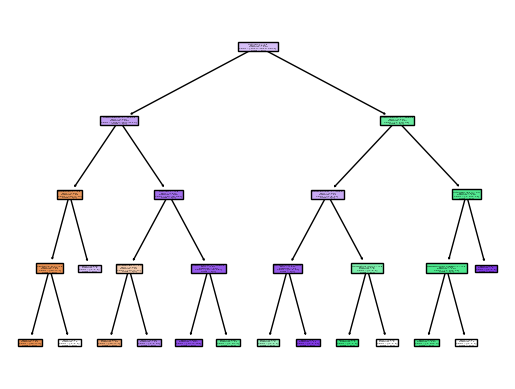

In [25]:
tree.plot_tree(clf,feature_names=df.columns, class_names=True, filled=True)

In [26]:
print ("Accuracy:", accuracy_score(y_test, y_pred))
print ("Precision:", precision_score(y_test,y_pred,average='weighted') )
print ("Recall: ", recall_score(y_test,y_pred,average='weighted'))

Accuracy: 0.7033898305084746
Precision: 0.7080262834684352
Recall:  0.7033898305084746


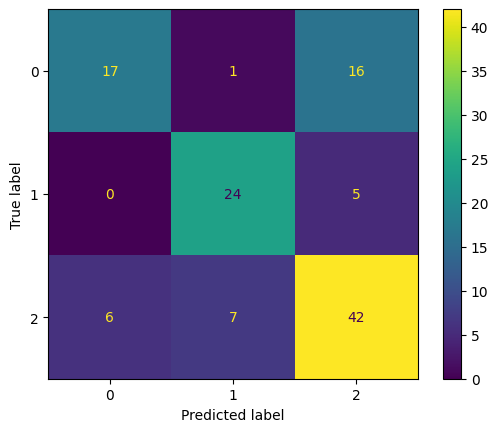

In [27]:
confusionMatrix = confusion_matrix(y_test, y_pred)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)
cmDisplay.plot()
plt.show()

In [28]:
depth = []
for i in range(4,15):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    scores = cross_val_score(estimator=clf, X=X, y=y, n_jobs=4)
    depth.append((i,scores.mean()))

print("Depth\tMean Score")
for d, score in depth:
    print(f"{d}\t{score:.6f}")

Depth	Mean Score
4	0.782298
5	0.775532
6	0.763639
7	0.785702
8	0.763653
9	0.767014
10	0.767058
11	0.758482
12	0.765319
13	0.746588
14	0.751746


### Random Forest Classifier

In [29]:
clf = RandomForestClassifier(max_depth=4, random_state=random_state) 
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [30]:
print ("Accuracy:", accuracy_score(y_test, y_pred))
print ("Precision:", precision_score(y_test,y_pred,average='weighted') )
print ("Recall: ", recall_score(y_test,y_pred,average='weighted'))

Accuracy: 0.7711864406779662
Precision: 0.8058367689723622
Recall:  0.7711864406779662


In [31]:
for depth in range(5, 15):
    model = RandomForestClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print (f"Accuracy for depth={depth}:", accuracy_score(y_test, y_pred))
    print (f"Precision for depth={depth}:", precision_score(y_test,y_pred,average='weighted'))
    print (f"Recall for depth={depth}: ", recall_score(y_test,y_pred,average='weighted'))
    print("------------------------------------------------")

Accuracy for depth=5: 0.7711864406779662
Precision for depth=5: 0.7838104205900817
Recall for depth=5:  0.7711864406779662
------------------------------------------------
Accuracy for depth=6: 0.8220338983050848
Precision for depth=6: 0.8356537530266345
Recall for depth=6:  0.8220338983050848
------------------------------------------------
Accuracy for depth=7: 0.8050847457627118
Precision for depth=7: 0.8112684527063968
Recall for depth=7:  0.8050847457627118
------------------------------------------------
Accuracy for depth=8: 0.8050847457627118
Precision for depth=8: 0.8149717514124294
Recall for depth=8:  0.8050847457627118
------------------------------------------------
Accuracy for depth=9: 0.8220338983050848
Precision for depth=9: 0.8279759151000265
Recall for depth=9:  0.8220338983050848
------------------------------------------------
Accuracy for depth=10: 0.8135593220338984
Precision for depth=10: 0.8229306788628822
Recall for depth=10:  0.8135593220338984
--------------

### Tree Depth Parameter Tuning

In [32]:
rf = RandomForestClassifier(n_estimators=100)

for depth in range(5, 15):
    param_grid = {'max_depth': [depth]}
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    print(f"Results for max_depth={depth}:")
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)

    results = pd.DataFrame(grid_search.cv_results_)
    print("------------------------------------------------")

Results for max_depth=5:
Best parameters: {'max_depth': 5}
Best cross-validation score: 0.8425531914893616
------------------------------------------------
Results for max_depth=6:
Best parameters: {'max_depth': 6}
Best cross-validation score: 0.8595744680851063
------------------------------------------------
Results for max_depth=7:
Best parameters: {'max_depth': 7}
Best cross-validation score: 0.8702127659574469
------------------------------------------------
Results for max_depth=8:
Best parameters: {'max_depth': 8}
Best cross-validation score: 0.8617021276595744
------------------------------------------------
Results for max_depth=9:
Best parameters: {'max_depth': 9}
Best cross-validation score: 0.8659574468085107
------------------------------------------------
Results for max_depth=10:
Best parameters: {'max_depth': 10}
Best cross-validation score: 0.8723404255319149
------------------------------------------------
Results for max_depth=11:
Best parameters: {'max_depth': 11}
B

En los resultados obtenidos anteriormente, es evidente que al incrementar la profundidad del árbol, el valor del cross-validation aumenta. Esto sugiere que al tener un árbol con mayor profundidad, es mejor para el desempeño del modelo. Aún así, al tener una mayor profundidad, se tendría un overfitting donde el modelo aprendería demasiado bien y procesaría muy poco el resto de data. 

### Selection of the Best Model

In [44]:
best_depth = grid_search.best_params_['max_depth']
final_model = RandomForestClassifier(n_estimators=100, max_depth=best_depth)

final_model.fit(X_train, y_train)

predictions = final_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Test set accuracy:", accuracy)

Test set accuracy: 0.8050847457627118


La precisión es menor a los valores del cross-validation, esto puede deberse a que el modelo está teniendo un overfitting con la data de entrenamiento.
También, puede estar ocurriendo porque existe una diferencia entre los datasets de entrenamiento y prueba que generan una distribución distinta a la esperada y su performance no es el más óptimo. 
A pesar de los puntos mencionados anteriormente, la precisión del modelo no es tan baja, por lo que se puede deber a la diferencia entre la distibución, más no al entrenamiento y el manejo de los datos.